<a href="https://colab.research.google.com/github/SurajK7/ChestAI/blob/master/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fastai.vision import *
from torchvision.models import *
from utils import *
import pandas as pd
from pathlib import Path

In [ ]:
cp /content/drive/My\ Drive/CheXpert-v1.0-small.zip .

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
!unzip -qq CheXpert-v1.0-small.zip
!rm CheXpert-v1.0-small.zip

In [ ]:
full_train_df = pd.read_csv('./CheXpert-v1.0-small/train.csv')
full_train_df = add_columns(full_train_df, False)

In [ ]:
full_valid_df = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
full_valid_df = add_columns(full_valid_df, True)

In [ ]:
# function to create class labels
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [ ]:
full_df = pd.concat([full_train_df, full_valid_df])
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [ ]:
tfms = get_transforms(do_flip=False, max_zoom=1.0, max_lighting=0.1)

In [ ]:
src = ImageList.from_df(full_df, '.', 'Path').split_from_df('train_valid').label_from_df('feature_string',label_delim=';')

In [ ]:
data = src.transform(tfms, size=320, padding_mode='zeros', resize_method=ResizeMethod.PAD).databunch(bs=59).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.densenet121, pretrained=True, metrics=avg_auc_metric, ps=0.0)

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 8.32E-03


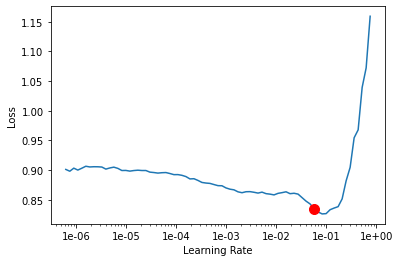

In [ ]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [12]:
lr = 4e-2

In [ ]:
learn.fit_one_cycle(8, slice(lr), wd=0.1, callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='avg_auc_metric', name='regularization_mixed')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.401944,0.442073,0.879643,1:04:33
1,0.407065,0.506797,0.838753,1:03:42
2,0.422753,0.473178,0.866748,1:01:23
3,0.413680,0.433504,0.827011,1:01:58
4,0.400357,0.544269,0.819738,1:02:11
5,0.397046,0.421506,0.877722,1:02:01
6,0.388775,0.429145,0.872978,1:02:06


In [ ]:
import shutil
shutil.make_archive('models', 'zip', 'models')
from google.colab import files
files.download('models.zip') 

In [11]:
learn.load('regularization_mixed_0')

Learner(data=ImageDataBunch;

Train: LabelList (64 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
,Atelectasis;Edema,,,Edema
Path: .;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
Cardiomegaly,,,Edema,
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(in

In [12]:
validation_eval(learn, full_valid_df)

234 234
Atelectasis     	 auc: 0.842	 chexpert auc: 0.858	 difference:    0.0162
Cardiomegaly    	 auc: 0.779	 chexpert auc: 0.854	 difference:    0.0754
Consolidation   	 auc: 0.915	 chexpert auc: 0.939	 difference:    0.0238
Edema           	 auc: 0.932	 chexpert auc: 0.941	 difference:    0.00896
Pleural Effusion	 auc: 0.92	 chexpert auc: 0.936	 difference:    0.0161

Average auc: 0.878 	 CheXpert average auc 0.906	 Difference 0.0281
